<h1>Sudoku Solving Agents!</h1>

Arjun Phull, ISTA 450 Final Project, 13 December 2023

In [176]:
from sudokuAgents import *
import matplotlib.pyplot as plt
import pandas as pd
import pickle

<code>sudokuAgents.py</code> implements the class <code>SudokuGame</code> and three solving algorithms. This notebook explains how to use them and compares their performance.

Let's first define some Sudoku boards:

In [161]:
# load in pre-generated sudoku boards
with open('testBoards.pickle', 'rb') as file:
    boards = pickle.load(file)

board1 = boards[20][1].copy()
board1

array([[5, '_', 4, '_', 7, 8, '_', '_', 2],
       ['_', '_', 2, '_', 9, '_', 3, 4, 8],
       [1, 9, 8, '_', 4, 2, 5, 6, 7],
       [8, 5, 9, 7, 6, '_', '_', 2, 3],
       [4, 2, 6, '_', 5, '_', 7, '_', 1],
       [7, 1, 3, 9, 2, 4, 8, 5, 6],
       [9, 6, 1, 5, '_', 7, 2, '_', 4],
       ['_', 8, 7, 4, 1, 9, 6, 3, 5],
       [3, '_', '_', '_', 8, 6, 1, 7, 9]], dtype=object)

<code>board1</code> is a partially filled Sudoku board with 20 open cells. <code>sol1</code> is its solution. We can import this board into a <code>SudokuGame</code> easily:

In [162]:
game = SudokuGame(board1.copy())
game.printBoard()

 5  _  4  _  7  8  _  _  2
 _  _  2  _  9  _  3  4  8
 1  9  8  _  4  2  5  6  7
 8  5  9  7  6  _  _  2  3
 4  2  6  _  5  _  7  _  1
 7  1  3  9  2  4  8  5  6
 9  6  1  5  _  7  2  _  4
 _  8  7  4  1  9  6  3  5
 3  _  _  _  8  6  1  7  9


The first solving algorithm is local search, implemented in <code>minConflicts</code>. This algorithm randomly assigns values to each empty cell. Then, it chooses a random cell and changes its value to the value that minimizes the total amount of conflicts. The algorithm repeats until a solution is found or a maximum number of iterations is reached.

In [163]:
game1 = SudokuGame(board1.copy())

# run minConflicts
conflictLog = minConflicts(game1, maxSteps=5000, plateauThreshold=20)

minConflicts:   0%|          | 0/5000 [00:00<?, ?it/s]

minConflicts:  11%|█▏        | 571/5000 [00:01<00:14, 306.13it/s]

Solved the board in 571 steps.
 5  3  4  6  7  8  9  1  2
 6  7  2  1  9  5  3  4  8
 1  9  8  3  4  2  5  6  7
 8  5  9  7  6  1  4  2  3
 4  2  6  8  5  3  7  9  1
 7  1  3  9  2  4  8  5  6
 9  6  1  5  3  7  2  8  4
 2  8  7  4  1  9  6  3  5
 3  4  5  2  8  6  1  7  9


<code>minConflicts</code> relies on random choice, so finding the solution to the same Sudoku board may take drastically different amounts of steps between runs. Additionally, since the assignments are random, <code>minConflicts</code> may never actually find the solution.

A more efficient approach is backtracking, as implemented in <code>backtrackingSearch</code>. This algorithm recursively assigns values to the first empty cell on the board. If a value assignment causes a conflict, the algorithm backtracks, reverses the assignment, and tries a new variable. Backtracking is guaranteed to find a solution!

In [164]:
game2 = SudokuGame(board1.copy())

# run backtracking
solution, timeElapsed = backtrackingSearch(game2)
print(f"Backtracking found the solution in {timeElapsed} seconds.")

Solution found in 20 steps!
 5  3  4  6  7  8  9  1  2
 6  7  2  1  9  5  3  4  8
 1  9  8  3  4  2  5  6  7
 8  5  9  7  6  1  4  2  3
 4  2  6  8  5  3  7  9  1
 7  1  3  9  2  4  8  5  6
 9  6  1  5  3  7  2  8  4
 2  8  7  4  1  9  6  3  5
 3  4  5  2  8  6  1  7  9
Backtracking found the solution in 0.007050037384033203 seconds.


Unlike <code>minConflicts</code>, backtracking can easily handle complex puzzles, such as this Sudoku board with 57 blank spaces:

In [165]:
board2 = boards[57][1]

game3 = SudokuGame(board2.copy())
game3.printBoard()
print('\n')

# run backtracking
solution, timeElapsed = backtrackingSearch(game3)
print(f"Backtracking found the solution in {timeElapsed} seconds.")

 5  _  4  6  _  _  _  1  2
 _  _  _  _  _  _  _  _  _
 _  9  _  3  4  _  _  _  _
 _  5  _  _  _  _  _  _  _
 _  2  6  _  5  _  _  9  _
 7  _  _  _  2  _  _  _  6
 _  _  1  5  _  7  _  _  _
 _  _  7  _  _  _  _  3  _
 3  _  _  _  _  _  1  7  _


Solution found in 57 steps!
 5  3  4  6  7  8  9  1  2
 1  7  8  2  9  5  3  6  4
 6  9  2  3  4  1  5  8  7
 4  5  9  1  8  6  7  2  3
 8  2  6  7  5  3  4  9  1
 7  1  3  4  2  9  8  5  6
 2  8  1  5  3  7  6  4  9
 9  6  7  8  1  4  2  3  5
 3  4  5  9  6  2  1  7  8
Backtracking found the solution in 0.09599709510803223 seconds.


Backtracking search is much faster than minConflicts, and it's guaranteed to find a solution. However, it fills in each empty value in order of its appearance on the board. While this is a consistent approach, it might not be the most efficient...

...which brings us to the last solver agent: <code>constraintProp</code>. This algorithm keeps record of all possible candidates for each empty cell on the board. Then, it recursively assigns values to the cell with the fewest candidate, and *propagates* the *constraints* after each assignment.

In [166]:
game4 = SudokuGame(board2.copy())

# run constraint propagation
solution, timeElapsed = constraintProp(game4)
print(f"Constraint propagation found the solution in {timeElapsed} seconds.")

Solution found in 57 steps.
 5  3  4  6  7  8  9  1  2
 1  7  8  2  9  5  4  6  3
 6  9  2  3  4  1  8  5  7
 8  5  9  7  6  4  3  2  1
 4  2  6  1  5  3  7  9  8
 7  1  3  8  2  9  5  4  6
 2  4  1  5  3  7  6  8  9
 9  8  7  4  1  6  2  3  5
 3  6  5  9  8  2  1  7  4
Constraint propagation found the solution in 0.03520917892456055 seconds.


<code>constraintProp</code> is observably faster than backtracking! To see how each of these algorithms compare, we can run some trials and plot the performance of each.

<h3>Comparing Performance</h3>

The file <code>testBoards.pickle</code> contains a dictionary called <code>boards</code>. The keys of <code>boards</code> represent a certain number of missing spaces on a Sudoku board (i.e. a way to quantify the difficulty of the board). Each key maps to a list of ten boards with that many spaces missing.

Note: <code>boards</code> only contains Sudoku boards with up to 57 blank spaces. This is because the New York Times' "hard" Sudoku puzzle has a maximum of 57 blank spaces. Theoretically, you could have a Sudoku puzzle with 80 blank spaces--but there would certainly be more than one solution, and it'd be no fun to solve. So, for the sake of this project, we're testing on 57 blank spaces or less!

The code used to generate <code>boards</code> is in the cell below:

In [167]:
## Code used to generate solvable test boards
# 
# testBoards = {i: list() for i in range(1,57)}
# 
# for i in range(1,57):
#     while len(testBoards[i]) < 10:
#         game = SudokuGame(redactCells(sol1, i))
#         board = copy.deepcopy(game.board)
#         solution = backtrackingSearch(game)
#         if solution is not None:
#             testBoards[i].append(board)
# 
# with open('testBoards.pickle', 'wb') as file:
#     pickle.dump(testBoards, file, protocol=pickle.HIGHEST_PROTOCOL)

To test the performance of local search, we can run <code>minConflicts</code> on each board and store the results in a <code>DataFrame</code>. The commented code below shows how to do this; but since this process took almost an hour to run, I've also included a CSV with the formatted data.

In [168]:
# minConflictRuns = pd.DataFrame(columns=['boardSize', 'conflicts'], index=np.arange(300))
# run = 0
# for size in tqdm(boards, desc="Sizes"):
#     if run > 299:
#         break
#     for i in tqdm(range(10), desc=f"Iterating over size {size}"):
#         game = SudokuGame(boards[size][i].copy())
#         minConflictRuns.boardSize[run] = size
#         minConflictRuns.conflicts[run] = minConflicts(game, maxSteps=5000, plateauThreshold=20, printOutput=False)
#         run += 1

# for i in minConflictRuns.index:
#     if minConflictRuns.loc[i, 'conflicts'][-1] == 0:
#         minConflictRuns.loc[i, 'success'] = True  # create a success column
#     minConflictRuns.loc[i, 'steps'] = len(minConflictRuns.loc[i, 'conflicts'])  # get the number of steps

# minConflictRuns.to_csv('minConflictRuns.csv')

minConflictRuns = pd.read_csv('minConflictRuns.csv', index_col=0)
minConflictRuns

,boardSize,conflicts,success,steps
0,1,"[6, 0]",True,2
1,1,"[6, 0]",True,2
2,1,"[6, 0]",True,2
3,1,"[6, 0]",True,2
4,1,"[6, 0]",True,2
...,...,...,...,...
295,30,"[126, 126, 124, 122, 116, 112, 108, 106, 106, ...",False,5000
296,30,"[128, 124, 124, 120, 116, 114, 114, 110, 106, ...",False,5000
297,30,"[134, 132, 122, 120, 116, 104, 104, 104, 104, ...",True,1178
298,30,"[160, 152, 146, 134, 132, 132, 128, 128, 124, ...",True,782


Let's plot the average number of steps that <code>minConflicts</code> took for each puzzle.

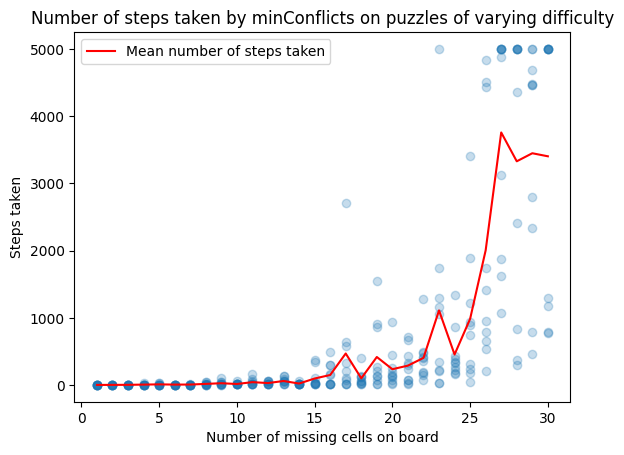

In [169]:
plt.plot(minConflictRuns.groupby('boardSize')['steps'].mean(), color='red', label='Mean number of steps taken')
plt.scatter(minConflictRuns.boardSize, minConflictRuns.steps, alpha=0.25)
plt.title('Number of steps taken by minConflicts on puzzles of varying difficulty')
plt.xlabel('Number of missing cells on board')
plt.ylabel('Steps taken')
# plt.yscale('log')
plt.legend()
plt.show()

<code>minConflicts</code> appears to be effective for boards with fewer missing cells. After about 25 missing cells, though, the number of steps taken spikes, suggesting that local search performs better with easier problems.

We can take a closer look at how the <code>minConflicts</code> algorithm works by examining the step progression of a certain run.

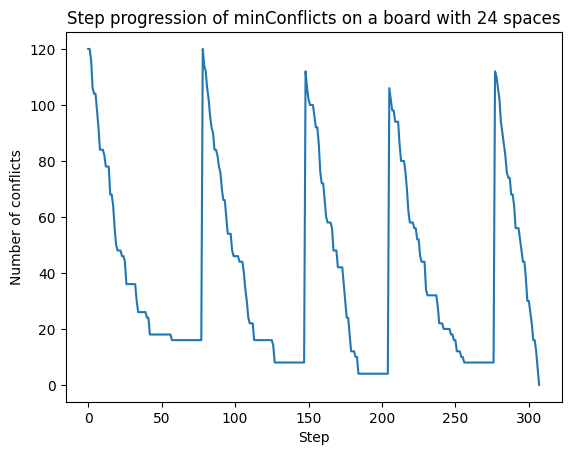

In [170]:
run = 243
conflicts = [int(x) for x in minConflictRuns.conflicts[run].strip('[]').split(', ')]
plt.plot(conflicts)
plt.title(f"Step progression of minConflicts on a board with {run // 10} spaces")
plt.xlabel('Step')
plt.ylabel('Number of conflicts')
plt.show()

As the graph shows, <code>minConflicts</code> starts at a point of high conflicts and iteratively reduces the number of total conflicts. If the number of conflicts does not improve after successive iterations, the algorithm is said to have reached a *plateau*, and the editable values are re-randomized.

Let's now take a look at the backtracking algorithm's performance. We'll start by running backtracking on each of the boards in <code>boards</code>.

In [171]:
# backtrackingRuns = pd.DataFrame(columns=['boardSize', 'solveTime'], index=np.arange(570))
# 
# run = 0
# for size in tqdm(boards, desc="Sizes"):
#     for i in tqdm(range(10), desc=f"Iterating over size {size}"):
#         game = SudokuGame(boards[size][i].copy())
#         backtrackingRuns.boardSize[run] = size
#         backtrackingRuns.solveTime[run] = backtrackingSearch(game, printOutput=False)[1]
#         run += 1
# 
# backtrackingRuns.to_csv('backtrackingRuns.csv')
backtrackingRuns = pd.read_csv('backtrackingRuns.csv', index_col=0)
backtrackingRuns

,boardSize,solveTime
0,1,0.000874
1,1,0.000853
2,1,0.000846
3,1,0.000876
4,1,0.000827
...,...,...
565,57,1.563849
566,57,0.213989
567,57,0.053597
568,57,3.967723


Let's take a look at how backtracking performed:

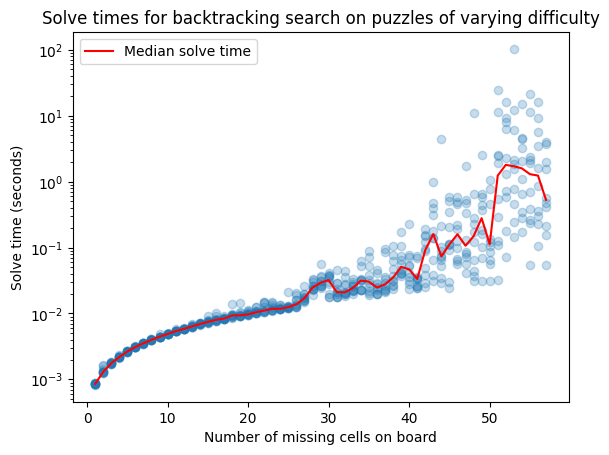

In [172]:
plt.scatter(backtrackingRuns.boardSize, backtrackingRuns.solveTime, alpha=0.25)
plt.title('Solve times for backtracking search on puzzles of varying difficulty')
plt.xlabel('Number of missing cells on board')
plt.ylabel('Solve time (seconds)')
plt.yscale('log')
plt.plot(backtrackingRuns.groupby('boardSize')['solveTime'].median(), color='red', label='Median solve time')
plt.legend()
plt.show()

As the graph shows, backtracking performs very well for most board difficulties. As the boards get harder, the algorithm may take more time to solve it, but the median solve time is no more than 10 seconds for even the hardest puzzles.

Let's now take a look at <code>constraintProp</code>'s performance. We'll run it on each of the boards as we did previously. The below code runs in about 10 seconds, but for consistency's sake, I've included a CSV.

In [173]:
# constraintPropRuns = pd.DataFrame(columns=['boardSize', 'solveTime'], index=np.arange(570))
# 
# run = 0
# for size in tqdm(boards, desc="Sizes"):
#     for i in tqdm(range(10), desc=f"Iterating over size {size}"):
#         game = SudokuGame(boards[size][i].copy())
#         constraintPropRuns.boardSize[run] = size
#         constraintPropRuns.solveTime[run] = constraintProp(game, printOutput=False)[1]
#         run += 1

constraintPropRuns = pd.read_csv('constraintPropRuns.csv', index_col=0)
constraintPropRuns

,boardSize,solveTime
0,1,0.000647
1,1,0.000261
2,1,0.000261
3,1,0.000259
4,1,0.000255
...,...,...
565,57,0.038629
566,57,0.051500
567,57,0.052406
568,57,0.100701


We'll plot performance the same way we did for backtracking:

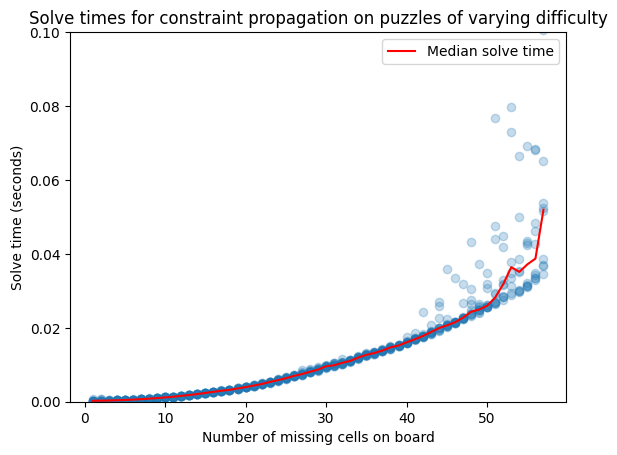

In [174]:
plt.scatter(constraintPropRuns.boardSize, constraintPropRuns.solveTime, alpha=0.25)
plt.title('Solve times for constraint propagation on puzzles of varying difficulty')
plt.xlabel('Number of missing cells on board')
plt.ylabel('Solve time (seconds)')
# plt.yscale('log')
plt.ylim(0, 0.1)
plt.plot(constraintPropRuns.groupby('boardSize')['solveTime'].median(), color='red', label='Median solve time')
plt.legend()
plt.show()

This is a huge improvement over backtracking search! Even the hardest Sudoku games fall to <code>constraintProp</code> in less than a tenth of a second.

We can directly compare backtracking and constraint propagation performance:

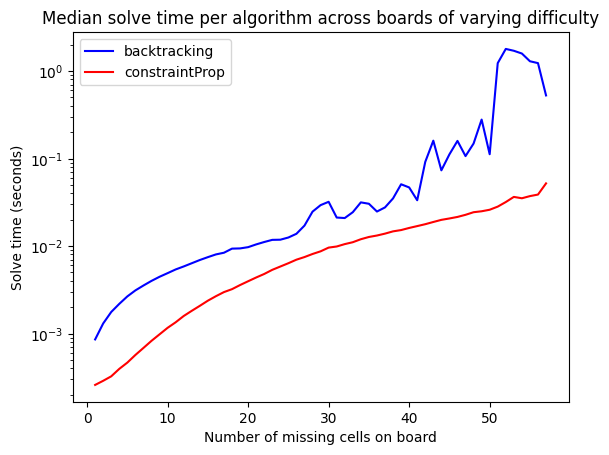

In [175]:
plt.plot(backtrackingRuns.groupby('boardSize')['solveTime'].median(), color='blue', label='backtracking')
plt.plot(constraintPropRuns.groupby('boardSize')['solveTime'].median(), color='red', label='constraintProp')
plt.title("Median solve time per algorithm across boards of varying difficulty")
plt.legend()
plt.xlabel('Number of missing cells on board')
plt.ylabel('Solve time (seconds)')
plt.yscale('log')
plt.show()

It's evident that <code>constraintProp</code> is king!